# Battle of Neighbourhood

In [1]:
%matplotlib inline
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library
# import matplotlib as mpl
import matplotlib.pyplot as plt


The below dataset has been collected from Kaggle. it can be downloaded from  <a href="https://www.kaggle.com/etiennelq/french-employment-by-town">this link</a>

we have used the french dmeographic data to collect information about two big cities of France . One of them is __Paris__ (National capital City) and  second is __Strasbourg__ . Both of these places are famous for International Tourism.

## information about dataset
* EU_circo : name of the European Union Circonscription
* code_région : code of the region attached to the town
* nom_région : name of the region attached to the town
* chef.lieu_région : name the administrative center around the town
* numéro_département : code of the department attached to the town
* nom_département : name of the department attached to the town
* préfecture : name of the local administrative division around the town
* numéro_circonscription : number of the circumpscription
* nom_commune : name of the town
* codes_postaux : post-codes relative to the town
* code_insee : unique code for the town
* latitude : GPS latitude
* longitude : GPS longitude


In [4]:
french_df = pd.read_csv("name_geographic_information.csv")
french_df.head()

,EU_circo,code_région,nom_région,chef.lieu_région,numéro_département,nom_département,préfecture,numéro_circonscription,nom_commune,codes_postaux,code_insee,latitude,longitude,éloignement
0,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Attignat,01340,1024,46.283333,5.166667,1.21
1,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Beaupont,01270,1029,46.400000,5.266667,1.91
2,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Bény,01370,1038,46.333333,5.283333,1.51
3,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Béreyziat,01340,1040,46.366667,5.05,1.71
4,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Bohas-Meyriat-Rignat,01250,1245,46.133333,5.4,1.01


In [5]:
french_df.shape

(36840, 14)

In [7]:
french_df.préfecture.unique()

array(['Bourg-en-Bresse', 'Laon', 'Ajaccio', 'Bastia', 'Moulins',
       'Digne-les-Bains', 'Gap', 'Nice', 'Privas', 'Charleville-Mézières',
       'Foix', 'Troyes', 'Carcassonne', 'Rodez', 'Marseille', 'Caen',
       'Aurillac', 'Angoulême', 'La Rochelle', 'Bourges', 'Tulle',
       'Dijon', 'Saint-Brieuc', 'Guéret', 'Périgueux', 'Besançon',
       'Valence', 'Évreux', 'Chartres', 'Quimper', 'Nîmes', 'Toulouse',
       'Auch', 'Bordeaux', 'Montpellier', 'Rennes', 'Châteauroux',
       'Tours', 'Grenoble', 'Lons-le-Saunier', 'Mont-de-Marsan', 'Blois',
       'Saint-Étienne', 'Le Puy-en-Velay', 'Nantes', 'Orléans', 'Cahors',
       'Agen', 'Mende', 'Angers', 'Saint-Lô', 'Châlons-en-Champagne',
       'Chaumont', 'Laval', 'Nancy', 'Bar-le-Duc', 'Vannes', 'Metz',
       'Nevers', 'Lille', 'Beauvais', 'Alençon', 'Arras',
       'Clermont-Ferrand', 'Pau', 'Tarbes', 'Perpignan', 'Strasbourg',
       'Colmar', 'Lyon', 'Vesoul', 'Mâcon', 'Le Mans', 'Chambéry',
       'Annecy', 'Paris', 'Rouen'

#### Let's select only those regions that fall under two major cities of France as we are only interested in comparision between these tho tousrist place

In [8]:
french_df = french_df[french_df.préfecture.isin( ['Paris','Strasbourg'])]

In [9]:
french_df.shape

(550, 14)

#### Let's drop inapproprite columns

In [10]:
french_df.drop(['chef.lieu_région','EU_circo','code_région','nom_région','numéro_département','nom_département','numéro_circonscription','code_insee','éloignement'],axis = 1,inplace = True)

In [11]:
french_df = french_df.reset_index(drop = True)

In [12]:
french_df.rename(columns  ={'préfecture':'Borough','nom_commune':'Neighborhood','codes_postaux':'Postal-codes'},inplace = True)

In [13]:
# french_df.drop(['index'],inplace = True,axis = 1)

In [14]:
french_df.head()

,Borough,Neighborhood,Postal-codes,latitude,longitude
0,Strasbourg,Strasbourg,67000,48.583333,7.75
1,Strasbourg,Strasbourg,67000,48.583333,7.75
2,Strasbourg,Bischheim,67800,48.616667,7.75
3,Strasbourg,Hoenheim,67800,48.616667,7.75
4,Strasbourg,Schiltigheim,67300,48.600000,7.75


## Data Wrangling

#### let's check for null NaN values

In [15]:
french_df.isnull().any()

Borough         False
Neighborhood    False
Postal-codes    False
latitude         True
longitude        True
dtype: bool

In [16]:
french_df.shape

(550, 5)

#### Lets' drop entire rows having any NaN values

 replace "-" with __NaN__  value in __longitue__ column

In [17]:
for index,ele in enumerate(french_df.longitude):
    if ele is "-":
        french_df.iloc[index,4] = np.nan

In [225]:
french_df.longitude.str.replace(",",".")

In [19]:
french_df.dropna(axis =0,inplace = True)
french_df.shape

(519, 5)

In [20]:
french_df.dtypes

Borough          object
Neighborhood     object
Postal-codes     object
latitude        float64
longitude        object
dtype: object

In [21]:
french_df['longitude'] = french_df['longitude'].astype(np.float)

In [22]:
address = 'Paris,Strasbourg,France'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of France is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of France is 48.5855998, 7.7435029.


In [23]:
french_map = folium.Map(location=[latitude, longitude], zoom_start=10)
# add markers to map
for lat,lng,borough,neighbours in zip(french_df.latitude,french_df.longitude,french_df.Borough,french_df.Neighborhood):
    label = "{}, {}".format(neighbours,borough)
    label = folium.Popup(label,parse_html = True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(french_map)  
    
french_map

Neighbourhood looks quite messed up! Just beacause we are dealing with  all the palces located in south-eastern France. Let's cluster these places to look sparse.

In [24]:
from folium import plugins

# let's start again with a clean copy of the map of south-eastern France
french_map = folium.Map(location = [latitude, longitude], zoom_start = 6)

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(french_map)

# loop through the dataframe and add each data point to the mark cluster
for lat,lng,borough,neighbours in zip(french_df.latitude,french_df.longitude,french_df.Borough,french_df.Neighborhood):
    label = "{}, {}".format(neighbours,borough)
    label = folium.Popup(label,parse_html = True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(incidents)  
# display map
french_map

#### Now we will be using Foursquare API to explore venues in the neighbourhood of all the places

In [25]:
CLIENT_ID = 'R1G20ERTATMX4DZOXBF35FXWD3UMXGR41HXYQJDUSNGQN532' # your Foursquare ID
CLIENT_SECRET = 'WLNPANWI2MHCBIFBH4YVJYPSRKH1PLYP4DB5QUHO0U1ETTSI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: R1G20ERTATMX4DZOXBF35FXWD3UMXGR41HXYQJDUSNGQN532
CLIENT_SECRET:WLNPANWI2MHCBIFBH4YVJYPSRKH1PLYP4DB5QUHO0U1ETTSI


Now, Lets get the top 100 venues thar are in Rhino Alpes region of south-eastern France 

In [26]:
def getnearbyVenues(names,latitude,longitude,radius = 500):
    venues_list=[]
#     category = ['4d4b7104d754a06370d81259','4d4b7105d754a06372d81259','4d4b7105d754a06374d81259','4d4b7105d754a06377d81259','4d4b7105d754a06375d81259','4e67e38e036454776db1fb3a','4d4b7105d754a06378d81259','4d4b7105d754a06379d81259','']
    for name,lat,lng in zip(names,latitude,longitude):
            
#             print(name)
            # create url to explore the venues
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
#             current_status = False
            
            results = requests.get(url).json()['response']
#             print(results)
            if results:
                print(name)
                results = results['groups'][0]['items']
                venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
    return venues_list
   

In [27]:
def returnDataFrame(venues_list):
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    return(nearby_venues)

In [32]:
venue_arr = getnearbyVenues(names = french_df['Neighborhood'],latitude = french_df['latitude'],longitude = french_df['longitude'])

Strasbourg
Strasbourg
Bischheim
Hoenheim
Schiltigheim
Strasbourg
Achenheim
Berstett
Blaesheim
Breuschwickersheim
Dingsheim
Dossenheim-Kochersberg
Duppigheim
Durningen
Eckbolsheim
Entzheim
Eschau
Fegersheim
Fessenheim-le-Bas
Furdenheim
Geispolsheim
Gougenheim
Handschuheim
Hangenbieten
Holtzheim
Hurtigheim
Illkirch-Graffenstaden
Innenheim
Ittenheim
Kienheim
Kolbsheim
Kuttolsheim
Lampertheim
Lingolsheim
Lipsheim
Mittelhausbergen
Mundolsheim
Niederhausbergen
Oberhausbergen
Oberschaeffolsheim
Osthoffen
Ostwald
Pfettisheim
Pfulgriesheim
Plobsheim
Quatzenheim
Reichstett
Rohr
Schnersheim
Souffelweyersheim
Truchtersheim
Willgottheim
Wintzenheim-Kochersberg
Wiwersheim
Wolfisheim
Artolsheim
Baldenheim
Barr
Benfeld
Bernardswiller
Bernardvillé
Bindernheim
Blienschwiller
Boesenbiesen
Bolsenheim
Boofzheim
Bootzheim
Bourgheim
Châtenois
Dambach-la-Ville
Daubensand
Diebolsheim
Dieffenthal
Ebersheim
Ebersmunster
Eichhoffen
Elsenheim
Epfig
Erstein
Friesenheim
Gerstheim
Gertwiller
Goxwiller
Heidolsheim
Hei

In [34]:
len(venue_arr)

519

In [35]:
france_venues = returnDataFrame(venue_arr)
france_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Strasbourg,48.583333,7.75,Amorino,48.581489,7.749795,Ice Cream Shop
1,Strasbourg,48.583333,7.75,Place de la Cathédrale,48.581544,7.750195,Plaza
2,Strasbourg,48.583333,7.75,Le Saint-Sépulcre,48.582451,7.749090,Alsatian Restaurant
3,Strasbourg,48.583333,7.75,Au Crocodile,48.583712,7.747542,French Restaurant
4,Strasbourg,48.583333,7.75,Maison Lorho,48.582866,7.748701,Cheese Shop


In [37]:
france_venues.shape

(2793, 7)

#### Let's explore these cities one by one

we will be exploring __Strasbourg__ first

In [50]:
strasbourg_venues = france_venues[france_venues.Neighborhood == 'Strasbourg']
strasbourg_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Strasbourg,48.583333,7.75,Amorino,48.581489,7.749795,Ice Cream Shop
1,Strasbourg,48.583333,7.75,Place de la Cathédrale,48.581544,7.750195,Plaza
2,Strasbourg,48.583333,7.75,Le Saint-Sépulcre,48.582451,7.749090,Alsatian Restaurant
3,Strasbourg,48.583333,7.75,Au Crocodile,48.583712,7.747542,French Restaurant
4,Strasbourg,48.583333,7.75,Maison Lorho,48.582866,7.748701,Cheese Shop


In [51]:
strasbourg_venues.shape

(228, 7)

In [53]:
strasbourg_venues['Venue Category'].unique()

array(['Ice Cream Shop', 'Plaza', 'Alsatian Restaurant',
       'French Restaurant', 'Cheese Shop', 'Sandwich Place',
       'Cocktail Bar', 'Market', 'Opera House', 'Restaurant',
       'Beer Store', 'Vegetarian / Vegan Restaurant', 'Bar', 'Café',
       'Wine Bar', 'Hotel', 'Boutique', 'Karaoke Bar', 'Coffee Shop',
       'Indie Movie Theater', 'Art Museum', 'Tea Room', 'Bistro',
       'Cupcake Shop', 'Electronics Store', 'Bagel Shop',
       'History Museum', 'Indian Restaurant', 'Bakery', 'Clothing Store',
       'Bookstore', 'Theater', 'Mediterranean Restaurant',
       'Department Store', 'Sushi Restaurant', 'Gourmet Shop',
       'Japanese Restaurant', 'Fried Chicken Joint'], dtype=object)

In [54]:
strasbourg_venues.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Alsatian Restaurant,15,15,15,15,15,15
Art Museum,3,3,3,3,3,3
Bagel Shop,3,3,3,3,3,3
Bakery,3,3,3,3,3,3
Bar,24,24,24,24,24,24
Beer Store,3,3,3,3,3,3
Bistro,6,6,6,6,6,6
Bookstore,6,6,6,6,6,6
Boutique,3,3,3,3,3,3


Let's explore how many restaurants are there and what are their types

In [96]:
strasbourg_restaraunts = strasbourg_venues[[ele.find('Restaurant')!=-1  for ele in strasbourg_venues['Venue Category'] ]].reset_index(drop = True)
strasbourg_restaraunts.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Strasbourg,48.583333,7.75,Le Saint-Sépulcre,48.582451,7.749090,Alsatian Restaurant
1,Strasbourg,48.583333,7.75,Au Crocodile,48.583712,7.747542,French Restaurant
2,Strasbourg,48.583333,7.75,Binchstub,48.583205,7.752674,Alsatian Restaurant
3,Strasbourg,48.583333,7.75,La Petite Mairie,48.584594,7.751461,French Restaurant
4,Strasbourg,48.583333,7.75,Chez Yvonne,48.582798,7.749594,Alsatian Restaurant


In [232]:
strasbourg_restaraunts.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Alsatian Restaurant,15,15,15,15,15,15
French Restaurant,27,27,27,27,27,27
Indian Restaurant,3,3,3,3,3,3
Japanese Restaurant,3,3,3,3,3,3
Mediterranean Restaurant,3,3,3,3,3,3
Restaurant,9,9,9,9,9,9
Sushi Restaurant,3,3,3,3,3,3
Vegetarian / Vegan Restaurant,6,6,6,6,6,6


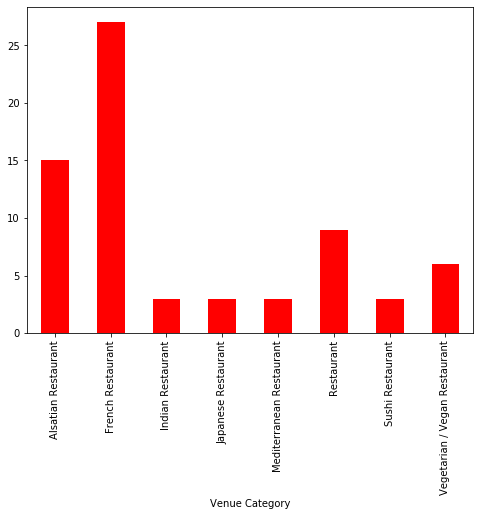

In [182]:
strasbourg_restaraunts.groupby('Venue Category').count()['Venue'].plot(kind = 'bar',figsize =(8,6),color = 'red')

As we can see from the above plot that Starsbourg is having maximum number of French restaurants in it's neighbourhood, followed by Alsatian restaurants.

Now , Let's explore __Paris__  

In [88]:
paris_venues = france_venues[france_venues.Neighborhood == 'Paris']
paris_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
693,Paris,48.866667,2.333333,Pierre Hermé,48.868222,2.333397,Pastry Shop
694,Paris,48.866667,2.333333,Cantine California,48.867401,2.332017,Food Truck
695,Paris,48.866667,2.333333,Nolinski,48.865367,2.334584,Hotel
696,Paris,48.866667,2.333333,Brentano's,48.868112,2.333508,Bookstore
697,Paris,48.866667,2.333333,Le Roch Hotel & Spa Paris,48.866200,2.332995,Hotel


In [89]:
paris_venues.shape

(2100, 7)

In [90]:
paris_venues['Venue Category'].unique()

array(['Pastry Shop', 'Food Truck', 'Hotel', 'Bookstore',
       'Udon Restaurant', 'Bakery', 'Japanese Restaurant',
       "Women's Store", 'Restaurant', 'Gym', 'Theater',
       'Korean Restaurant', 'Coffee Shop', 'Candy Store', 'Wine Bar',
       'Bubble Tea Shop', 'Italian Restaurant', 'Chocolate Shop',
       'Tea Room', 'Thai Restaurant', "Men's Store", 'Jewelry Store',
       'Cosmetics Shop', 'Plaza', 'Herbs & Spices Store',
       'Israeli Restaurant', 'French Restaurant', 'English Restaurant',
       'Cheese Shop', 'Furniture / Home Store', 'Taiwanese Restaurant',
       'Arts & Crafts Store', 'Convenience Store', 'Deli / Bodega',
       'Café', 'Seafood Restaurant', 'Cycle Studio', 'Garden',
       'Noodle House', 'Clothing Store', 'Grocery Store',
       'Sandwich Place', 'Dessert Shop', 'Sushi Restaurant',
       'Gourmet Shop', 'Burger Joint', 'Dance Studio'], dtype=object)

In [92]:
paris_venues.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Arts & Crafts Store,21,21,21,21,21,21
Bakery,21,21,21,21,21,21
Bookstore,63,63,63,63,63,63
Bubble Tea Shop,21,21,21,21,21,21
Burger Joint,21,21,21,21,21,21
Café,21,21,21,21,21,21
Candy Store,42,42,42,42,42,42
Cheese Shop,21,21,21,21,21,21
Chocolate Shop,42,42,42,42,42,42


Let's select only those rows which contains restaurants

In [98]:
paris_restaraunts = paris_venues[[ele.find('Restaurant')!=-1  for ele in paris_venues['Venue Category'] ]].reset_index(drop = True)
paris_restaraunts.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Paris,48.866667,2.333333,Sanukiya,48.864713,2.333805,Udon Restaurant
1,Paris,48.866667,2.333333,Jin,48.865348,2.331787,Japanese Restaurant
2,Paris,48.866667,2.333333,Restaurant Kunitoraya,48.866116,2.336467,Japanese Restaurant
3,Paris,48.866667,2.333333,Brasserie Réjane,48.865486,2.334824,Restaurant
4,Paris,48.866667,2.333333,Hakata Choten,48.867125,2.334818,Japanese Restaurant


In [236]:
paris_restaraunts.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
English Restaurant,21,21,21,21,21,21
French Restaurant,168,168,168,168,168,168
Israeli Restaurant,21,21,21,21,21,21
Italian Restaurant,147,147,147,147,147,147
Japanese Restaurant,273,273,273,273,273,273
Korean Restaurant,63,63,63,63,63,63
Restaurant,21,21,21,21,21,21
Seafood Restaurant,21,21,21,21,21,21
Sushi Restaurant,21,21,21,21,21,21


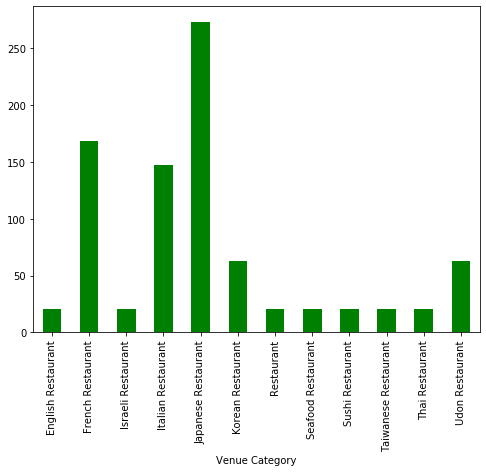

In [183]:
paris_restaraunts.groupby('Venue Category').count()['Venue'].plot(kind = 'bar',figsize =(8,6),color= 'green')

Let's concatenate these two bar graphs to compare the availabilty of restaurants within Strasbourg and Paris.

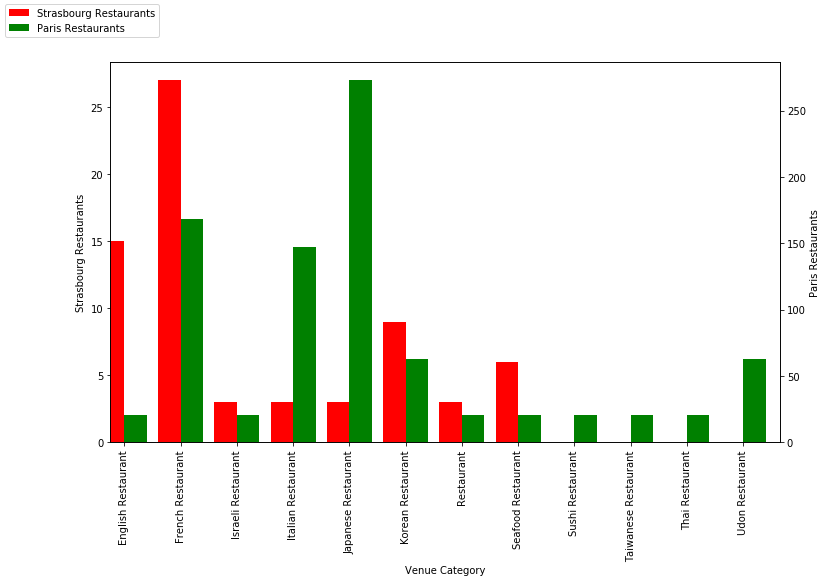

In [186]:
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

width=0.4
df1 = strasbourg_restaraunts.groupby('Venue Category').count()
df2 = paris_restaraunts.groupby('Venue Category').count()
df1=df1.set_index('Venue').sort_index()
df2=df2.set_index('Venue').sort_index()

lns1 = strasbourg_restaraunts.groupby('Venue Category').count()['Venue'].plot(kind='bar',color='red',ax=ax1,width=width,position=1)
lns2 = paris_restaraunts.groupby('Venue Category').count()['Venue'].plot(kind='bar',color='green',ax=ax2,width=width,position=0)

ax1.set_ylabel('Strasbourg Restaurants')
ax2.set_ylabel('Paris Restaurants')
fig.legend(labels =('Strasbourg Restaurants','Paris Restaurants'),loc = 'upper left')
# ax2.legend()
plt.show()


from the above figure, we can conclude that __Strasbourg__ is having more number of French restaurants which is even less than number of french restaurants in __Paris__ .<br> __Paris__ is having more number of Japanese restaurants which is even greater than total number of restaurants in __Strasbourg__.

In [38]:
france_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Achenheim,3,3,3,3,3,3
Adamswiller,1,1,1,1,1,1
Allenwiller,2,2,2,2,2,2
Altenheim,1,1,1,1,1,1
Aschbach,1,1,1,1,1,1
Auenheim,2,2,2,2,2,2
Avolsheim,1,1,1,1,1,1
Barembach,1,1,1,1,1,1
Bassemberg,1,1,1,1,1,1


Let's examine how many unique venues did we get

In [188]:
len(france_venues['Venue Category'].unique())

165

## Now we are ready to analyse the neighbourhood venues within Paris and Strasbourg

### Preprocessing

In [189]:
france_oh_encoded = pd.get_dummies(france_venues['Venue Category'])
france_oh_encoded.head()

,Accessories Store,Alsatian Restaurant,Art Museum,Arts & Crafts Store,Athletics & Sports,Auto Workshop,Automotive Shop,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Bed & Breakfast,Beer Store,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Stop,Business Service,Café,Campground,Candy Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,City,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Discount Store,Electronics Store,English Restaurant,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Flea Market,Flower Shop,Food & Drink Shop,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Home Service,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Inn,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Laundromat,Locksmith,Lounge,Market,Medical Supply Store,Mediterranean Restaurant,Men's Store,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Park,Pastry Shop,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool,Pub,Racetrack,Rental Car Location,Rental Service,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shop & Service,Soccer Field,Soccer Stadium,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tailor Shop,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Winery,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [190]:
france_oh_encoded.insert(france_oh_encoded.shape[1],'Neighborhood',france_venues['Neighborhood'])
france_oh_encoded =france_oh_encoded.iloc[:,::-1]

france_oh_encoded.head()

,Neighborhood,Women's Store,Winery,Wine Shop,Wine Bar,Vineyard,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Udon Restaurant,Turkish Restaurant,Tram Station,Train Station,Trail,Toy / Game Store,Tourist Information Center,Theme Park,Theater,Thai Restaurant,Tea Room,Taiwanese Restaurant,Tailor Shop,Swiss Restaurant,Sushi Restaurant,Supermarket,Steakhouse,Stadium,Stables,Sports Club,Sporting Goods Shop,Soccer Stadium,Soccer Field,Shop & Service,Seafood Restaurant,Sandwich Place,Salon / Barbershop,Restaurant,Rental Service,Rental Car Location,Racetrack,Pub,Pool,Plaza,Playground,Pizza Place,Photography Studio,Pharmacy,Pastry Shop,Park,Outdoors & Recreation,Outdoor Supply Store,Other Repair Shop,Other Great Outdoors,Optical Shop,Opera House,Noodle House,Nightclub,Music Venue,Music Store,Museum,Multiplex,Mountain,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Men's Store,Mediterranean Restaurant,Medical Supply Store,Market,Lounge,Locksmith,Laundromat,Korean Restaurant,Karaoke Bar,Juice Bar,Jewelry Store,Japanese Restaurant,Italian Restaurant,Israeli Restaurant,Inn,Indie Movie Theater,Indian Restaurant,Ice Cream Shop,IT Services,Hotel Pool,Hotel Bar,Hotel,Home Service,History Museum,Historic Site,Herbs & Spices Store,Health & Beauty Service,Gym / Fitness Center,Gym,Grocery Store,Gourmet Shop,German Restaurant,General Entertainment,Gastropub,Gas Station,Garden Center,Garden,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Forest,Food Truck,Food & Drink Shop,Flower Shop,Flea Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market,Farm,Fabric Shop,English Restaurant,Electronics Store,Discount Store,Dessert Shop,Department Store,Dentist's Office,Deli / Bodega,Dance Studio,Cycle Studio,Cupcake Shop,Cosmetics Shop,Convenience Store,Construction & Landscaping,Comfort Food Restaurant,Coffee Shop,Cocktail Bar,Clothing Store,City,Chocolate Shop,Chinese Restaurant,Cheese Shop,Casino,Candy Store,Campground,Café,Business Service,Bus Stop,Burrito Place,Burger Joint,Bubble Tea Shop,Bridge,Brewery,Bowling Alley,Boutique,Bookstore,Boarding House,Bistro,Beer Store,Bed & Breakfast,Basketball Court,Bar,Bank,Bakery,Bagel Shop,Automotive Shop,Auto Workshop,Athletics & Sports,Arts & Crafts Store,Art Museum,Alsatian Restaurant,Accessories Store
0,Strasbourg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Strasbourg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Strasbourg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,Strasbourg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Strasbourg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0

#### Let's, replace each columns with mean of its frequency

In [191]:
france_grouped = france_oh_encoded.groupby('Neighborhood').mean().reset_index()

In [192]:
france_grouped.head(15)

,Neighborhood,Women's Store,Winery,Wine Shop,Wine Bar,Vineyard,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Udon Restaurant,Turkish Restaurant,Tram Station,Train Station,Trail,Toy / Game Store,Tourist Information Center,Theme Park,Theater,Thai Restaurant,Tea Room,Taiwanese Restaurant,Tailor Shop,Swiss Restaurant,Sushi Restaurant,Supermarket,Steakhouse,Stadium,Stables,Sports Club,Sporting Goods Shop,Soccer Stadium,Soccer Field,Shop & Service,Seafood Restaurant,Sandwich Place,Salon / Barbershop,Restaurant,Rental Service,Rental Car Location,Racetrack,Pub,Pool,Plaza,Playground,Pizza Place,Photography Studio,Pharmacy,Pastry Shop,Park,Outdoors & Recreation,Outdoor Supply Store,Other Repair Shop,Other Great Outdoors,Optical Shop,Opera House,Noodle House,Nightclub,Music Venue,Music Store,Museum,Multiplex,Mountain,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Men's Store,Mediterranean Restaurant,Medical Supply Store,Market,Lounge,Locksmith,Laundromat,Korean Restaurant,Karaoke Bar,Juice Bar,Jewelry Store,Japanese Restaurant,Italian Restaurant,Israeli Restaurant,Inn,Indie Movie Theater,Indian Restaurant,Ice Cream Shop,IT Services,Hotel Pool,Hotel Bar,Hotel,Home Service,History Museum,Historic Site,Herbs & Spices Store,Health & Beauty Service,Gym / Fitness Center,Gym,Grocery Store,Gourmet Shop,German Restaurant,General Entertainment,Gastropub,Gas Station,Garden Center,Garden,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Forest,Food Truck,Food & Drink Shop,Flower Shop,Flea Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market,Farm,Fabric Shop,English Restaurant,Electronics Store,Discount Store,Dessert Shop,Department Store,Dentist's Office,Deli / Bodega,Dance Studio,Cycle Studio,Cupcake Shop,Cosmetics Shop,Convenience Store,Construction & Landscaping,Comfort Food Restaurant,Coffee Shop,Cocktail Bar,Clothing Store,City,Chocolate Shop,Chinese Restaurant,Cheese Shop,Casino,Candy Store,Campground,Café,Business Service,Bus Stop,Burrito Place,Burger Joint,Bubble Tea Shop,Bridge,Brewery,Bowling Alley,Boutique,Bookstore,Boarding House,Bistro,Beer Store,Bed & Breakfast,Basketball Court,Bar,Bank,Bakery,Bagel Shop,Automotive Shop,Auto Workshop,Athletics & Sports,Arts & Crafts Store,Art Museum,Alsatian Restaurant,Accessories Store
0,Achenheim,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,Adamswiller,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,Allenwiller,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [193]:
france_grouped.shape

(203, 166)

In [194]:
france_grouped.dtypes

Neighborhood                      object
Women's Store                    float64
Winery                           float64
Wine Shop                        float64
Wine Bar                         float64
Vineyard                         float64
Vietnamese Restaurant            float64
Vegetarian / Vegan Restaurant    float64
Udon Restaurant                  float64
Turkish Restaurant               float64
Tram Station                     float64
Train Station                    float64
Trail                            float64
Toy / Game Store                 float64
Tourist Information Center       float64
Theme Park                       float64
Theater                          float64
Thai Restaurant                  float64
Tea Room                         float64
Taiwanese Restaurant             float64
Tailor Shop                      float64
Swiss Restaurant                 float64
Sushi Restaurant                 float64
Supermarket                      float64
Steakhouse      

####  Now, we will select the top five  venue in  each neighbourhood

In [195]:
temp_arr = []
for i,neighbor in enumerate(france_grouped.Neighborhood):
    print(f'-->{neighbor}<--\n')
    temp =france_grouped.iloc[i][1:].sort_values(ascending  = False)
    values = list(temp[:10].index)
    temp_arr.append(values)
    print(temp[:5],"\n")
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------\n")


-->Achenheim<--

Supermarket          0.666667
Bank                 0.333333
Accessories Store           0
Optical Shop                0
Multiplex                   0
Name: 0, dtype: object 

-------------------------------------------------------------------------------------------------------------------------------------------------------

-->Adamswiller<--

Furniture / Home Store    1
Mobile Phone Shop         0
Mountain                  0
Multiplex                 0
Museum                    0
Name: 1, dtype: object 

-------------------------------------------------------------------------------------------------------------------------------------------------------

-->Allenwiller<--

French Restaurant    0.5
Gastropub            0.5
Opera House            0
Mountain               0
Multiplex              0
Name: 2, dtype: object 

-----------------------------------------------------------------------------------------------------------------------------------------------------

Home Service         1
Accessories Store    0
Optical Shop         0
Mountain             0
Multiplex            0
Name: 123, dtype: object 

-------------------------------------------------------------------------------------------------------------------------------------------------------

-->Oberhausbergen<--

Mountain                      1
Modern European Restaurant    0
Multiplex                     0
Museum                        0
Music Store                   0
Name: 124, dtype: object 

-------------------------------------------------------------------------------------------------------------------------------------------------------

-->Oberhoffen-sur-Moder<--

Alsatian Restaurant           0.25
Construction & Landscaping    0.25
Flower Shop                   0.25
Bank                          0.25
Accessories Store                0
Name: 125, dtype: object 

-----------------------------------------------------------------------------------------------------------------

### Create a separate dataframe for top 10 venues in each neighbour

In [196]:
colomns = []
for i in range(10):
    colomns.append(f'{i+1} Most Common Venue')

neighborhood_venues_sorted = pd.DataFrame(temp_arr,columns =colomns)
neighborhood_venues_sorted.insert(0,'Neighborhood',france_grouped['Neighborhood'])        
neighborhood_venues_sorted.head()

,Neighborhood,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4 Most Common Venue,5 Most Common Venue,6 Most Common Venue,7 Most Common Venue,8 Most Common Venue,9 Most Common Venue,10 Most Common Venue
0,Achenheim,Supermarket,Bank,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House
1,Adamswiller,Furniture / Home Store,Mobile Phone Shop,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
2,Allenwiller,French Restaurant,Gastropub,Opera House,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House
3,Altenheim,Furniture / Home Store,Mobile Phone Shop,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
4,Aschbach,Construction & Landscaping,Accessories Store,Other Great Outdoors,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House


In [197]:
neighborhood_venues_sorted.shape

(203, 11)

## Let's perform clustering on above sorted dataframe

### Finding optimal number of K in K-Means clustering

We will be using __Gap statistic__  method to get the optimal number of K

In [198]:
def optimalK(data,max_cluster):
    
    result_df = pd.DataFrame({'gap':[],'cluster_count':[]})
    n_ref = 500
    gap_arr = np.zeros(max_cluster-1)
    
    original_inertia = np.zeros(max_cluster-1)
    reference_inertia = np.zeros(max_cluster-1)
    
    for gap_index,k in enumerate(range(1,max_cluster)):
        ref_set = np.zeros(n_ref)
        
        for i in range(n_ref):
            ref_dist = np.random.random_sample(data.shape)
            
            km  = KMeans(k)
            km.fit(ref_dist)
            
            ref_inertia = km.inertia_
            ref_set[i] = ref_inertia
            
        km_orig = KMeans(k)
        km_orig.fit(data)
        
        orig_inertia = km.inertia_
        original_inertia[gap_index] = np.log(orig_inertia)
        reference_inertia[gap_index] = np.mean([np.log(x) for x in ref_set])
        
        # calculate  gap statistics
        gap_statistics = np.mean([np.log(x) for x in ref_set]) - np.log(orig_inertia)
        gap_arr[gap_index] = gap_statistics
        
        result_df = result_df.append({'gap':gap_statistics,'cluster_count':k},ignore_index=True)
        
    return original_inertia,reference_inertia,gap_arr.argmax()+1,result_df

In [199]:
original_inertia,reference_inertia,optimal_k,gap_df = optimalK(france_grouped.iloc[:,1:],30)
print('original inertia = ',original_inertia,"\n")
print('null reference inertia = ',reference_inertia,"\n")
print("optimal value of k is = ",optimal_k)

original inertia =  [7.9315997  7.92739632 7.9006393  7.896205   7.89024845 7.88851919
 7.87181404 7.86434952 7.86006264 7.86655324 7.84800286 7.83289185
 7.83492745 7.8280243  7.80830535 7.80407721 7.79564142 7.78844712
 7.78902282 7.78789051 7.77884982 7.75825468 7.75312799 7.74252358
 7.74067871 7.74186505 7.72639215 7.71484417 7.7054159 ] 

null reference inertia =  [7.92903682 7.91463706 7.90433465 7.89555898 7.88743183 7.87964911
 7.87256805 7.86552237 7.85812968 7.85114051 7.84461632 7.83692866
 7.83015238 7.82296132 7.81566643 7.80869306 7.80097664 7.79381182
 7.78658397 7.77934898 7.77154165 7.76422295 7.75685355 7.74976868
 7.74224428 7.73440699 7.72721051 7.71942909 7.71249004] 

optimal value of k is =  15


#### let's plot the gap curve

In [201]:
gap_df.head()

,gap,cluster_count
0,-0.002563,1.0
1,-0.012759,2.0
2,0.003695,3.0
3,-0.000646,4.0
4,-0.002817,5.0


let's plot original dataframe within cluster distance vs null reference intracluster distance

Text(0, 0.5, 'corresponding gap curve')

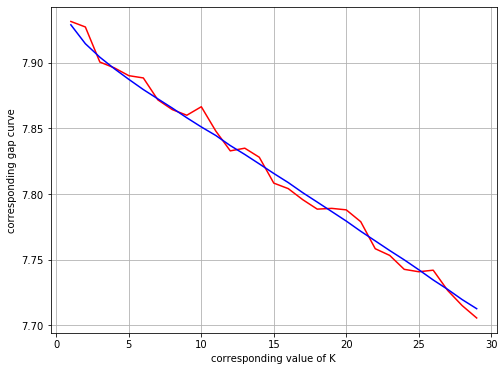

In [202]:
ax = plt.figure(figsize = (8,6))
ax1 = plt.plot([int(x) for x in range(1,30)],original_inertia,c = 'r')
plt.plot([int(x) for x in range(1,30)],reference_inertia,c ='b')
plt.grid()
plt.xlabel("corresponding value of K")
plt.ylabel("corresponding gap curve")

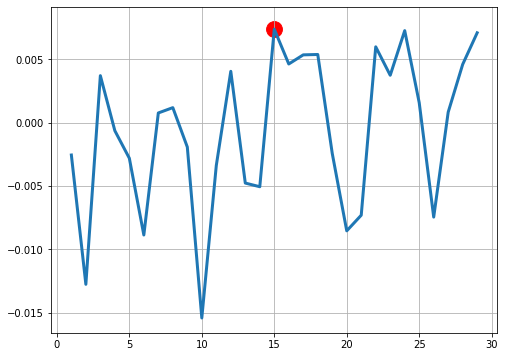

In [203]:
ax = plt.figure(figsize = (8,6))
plt.plot(gap_df.cluster_count,gap_df.gap,linewidth = 3)
plt.scatter(gap_df[gap_df.cluster_count == optimal_k].cluster_count,gap_df[gap_df.cluster_count == optimal_k].gap,s = 250,c ='r')
plt.grid()
plt.show()

let's use the above outplut of optimal k on raw dataset 

In [207]:
kmeans = KMeans(n_clusters=optimal_k).fit(france_grouped.iloc[:,1:])
labels =kmeans.labels_
labels[:10]
print(len(labels))

203


In [211]:
neighborhood_venues_sorted.columns

Index(['Neighborhood', '1 Most Common Venue', '2 Most Common Venue',
       '3 Most Common Venue', '4 Most Common Venue', '5 Most Common Venue',
       '6 Most Common Venue', '7 Most Common Venue', '8 Most Common Venue',
       '9 Most Common Venue', '10 Most Common Venue'],
      dtype='object')

In [212]:
neighborhood_venues_sorted.insert(0,'Cluster labels',labels)
france_merged = french_df.merge(neighborhood_venues_sorted,on = 'Neighborhood')

In [213]:
france_merged.head()

,Borough,Neighborhood,Postal-codes,latitude,longitude,Cluster labels,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4 Most Common Venue,5 Most Common Venue,6 Most Common Venue,7 Most Common Venue,8 Most Common Venue,9 Most Common Venue,10 Most Common Venue
0,Strasbourg,Strasbourg,67000,48.583333,7.75,1,French Restaurant,Bar,Plaza,Alsatian Restaurant,Restaurant,Hotel,Ice Cream Shop,Coffee Shop,Cocktail Bar,Clothing Store
1,Strasbourg,Strasbourg,67000,48.583333,7.75,1,French Restaurant,Bar,Plaza,Alsatian Restaurant,Restaurant,Hotel,Ice Cream Shop,Coffee Shop,Cocktail Bar,Clothing Store
2,Strasbourg,Strasbourg,67000,48.583333,7.75,1,French Restaurant,Bar,Plaza,Alsatian Restaurant,Restaurant,Hotel,Ice Cream Shop,Coffee Shop,Cocktail Bar,Clothing Store
3,Strasbourg,Bischheim,67800,48.616667,7.75,1,Gas Station,Italian Restaurant,Nightclub,Turkish Restaurant,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue
4,Strasbourg,Hoenheim,67800,48.616667,7.75,1,Gas Station,Italian Restaurant,Nightclub,Turkish Restaurant,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue


In [214]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)
kclusters = optimal_k
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(france_merged['latitude'], france_merged['longitude'], france_merged['Neighborhood'], france_merged['Cluster labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Lets examine each cluster one by one

#### let's explore each of these cluster one by one

#### cluster 1

In [215]:
france_merged.loc[france_merged['Cluster labels'] == 0,france_merged.columns[[1]+list(range(6, france_merged.shape[1]))]]

,Neighborhood,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4 Most Common Venue,5 Most Common Venue,6 Most Common Venue,7 Most Common Venue,8 Most Common Venue,9 Most Common Venue,10 Most Common Venue
43,Epfig,Train Station,Accessories Store,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
45,Goxwiller,Train Station,Miscellaneous Shop,Business Service,Modern European Restaurant,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House
54,Matzenheim,Train Station,Accessories Store,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
89,Muhlbach-sur-Bruche,Miscellaneous Shop,Train Station,Photography Studio,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House
96,Russ,Train Station,Accessories Store,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
136,Schwindratzheim,Train Station,Accessories Store,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
167,Schaffhouse-près-Seltz,Pizza Place,Train Station,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
171,Soultz-sous-Forêts,Train Station,Shop & Service,Accessories Store,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
194,Roeschwoog,Train Station,Accessories Store,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
199,Stattmatten,Train Station,Health & Beauty Service,Optical Shop,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House


#### cluster 2

In [216]:
france_merged.loc[france_merged['Cluster labels'] == 1,france_merged.columns[[1]+list(range(6, france_merged.shape[1]))]]

,Neighborhood,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4 Most Common Venue,5 Most Common Venue,6 Most Common Venue,7 Most Common Venue,8 Most Common Venue,9 Most Common Venue,10 Most Common Venue
0,Strasbourg,French Restaurant,Bar,Plaza,Alsatian Restaurant,Restaurant,Hotel,Ice Cream Shop,Coffee Shop,Cocktail Bar,Clothing Store
1,Strasbourg,French Restaurant,Bar,Plaza,Alsatian Restaurant,Restaurant,Hotel,Ice Cream Shop,Coffee Shop,Cocktail Bar,Clothing Store
2,Strasbourg,French Restaurant,Bar,Plaza,Alsatian Restaurant,Restaurant,Hotel,Ice Cream Shop,Coffee Shop,Cocktail Bar,Clothing Store
3,Bischheim,Gas Station,Italian Restaurant,Nightclub,Turkish Restaurant,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue
4,Hoenheim,Gas Station,Italian Restaurant,Nightclub,Turkish Restaurant,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue
5,Schiltigheim,French Restaurant,Park,Plaza,Grocery Store,Hotel,Vietnamese Restaurant,Tram Station,Bus Stop,Seafood Restaurant,Multiplex
8,Dingsheim,Food & Drink Shop,Accessories Store,Modern European Restaurant,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
10,Durningen,Electronics Store,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
11,Eckbolsheim,Supermarket,Fast Food Restaurant,Bus Stop,Home Service,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House
13,Eschau,Bus Stop,Hotel Bar,Italian Restaurant,Accessories Store,Other Great Outdoors,Museum,Music Store,Music Venue,Nightclub,Noodle House


#### cluster 3

In [217]:
france_merged.loc[france_merged['Cluster labels'] == 2,france_merged.columns[[1]+list(range(6, france_merged.shape[1]))]]

,Neighborhood,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4 Most Common Venue,5 Most Common Venue,6 Most Common Venue,7 Most Common Venue,8 Most Common Venue,9 Most Common Venue,10 Most Common Venue
42,Eichhoffen,Construction & Landscaping,Accessories Store,Other Great Outdoors,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
47,Hindisheim,Construction & Landscaping,Italian Restaurant,Accessories Store,Other Great Outdoors,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
65,Sand,Hotel,Construction & Landscaping,Accessories Store,Other Great Outdoors,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
66,Schaeffersheim,Construction & Landscaping,Accessories Store,Other Great Outdoors,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
72,Avolsheim,Construction & Landscaping,Accessories Store,Other Great Outdoors,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
102,Wasselonne,Construction & Landscaping,Plaza,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House
104,Wolxheim,Construction & Landscaping,Accessories Store,Other Great Outdoors,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
141,Wingen-sur-Moder,Modern European Restaurant,Construction & Landscaping,Other Great Outdoors,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
145,Aschbach,Construction & Landscaping,Accessories Store,Other Great Outdoors,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
148,Cleebourg,Construction & Landscaping,Accessories Store,Other Great Outdoors,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House


#### cluster 4

In [218]:
france_merged.loc[france_merged['Cluster labels'] == 3,france_merged.columns[[1]+list(range(6, france_merged.shape[1]))]]

,Neighborhood,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4 Most Common Venue,5 Most Common Venue,6 Most Common Venue,7 Most Common Venue,8 Most Common Venue,9 Most Common Venue,10 Most Common Venue
75,Dachstein,Restaurant,Farmers Market,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House
82,Griesheim-près-Molsheim,Restaurant,Outdoors & Recreation,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House
116,Haegen,Restaurant,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
131,Rosteig,Restaurant,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
144,Zittersheim,Restaurant,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
176,Auenheim,Automotive Shop,Restaurant,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House
188,Hochstett,Restaurant,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
193,Offendorf,Restaurant,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
197,Sessenheim,Restaurant,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
200,Uhlwiller,Restaurant,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House


#### cluster 5

In [219]:
france_merged.loc[france_merged['Cluster labels'] == 4,france_merged.columns[[1]+list(range(6, france_merged.shape[1]))]]

,Neighborhood,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4 Most Common Venue,5 Most Common Venue,6 Most Common Venue,7 Most Common Venue,8 Most Common Venue,9 Most Common Venue,10 Most Common Venue
7,Breuschwickersheim,French Restaurant,Modern European Restaurant,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
12,Entzheim,French Restaurant,Rental Car Location,Outdoors & Recreation,Opera House,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub
17,Gougenheim,French Restaurant,Modern European Restaurant,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
31,Reichstett,French Restaurant,Grocery Store,Plaza,Dessert Shop,Restaurant,Multiplex,Museum,Music Store,Music Venue,Nightclub
33,Willgottheim,French Restaurant,Restaurant,Optical Shop,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House
59,Nordhouse,French Restaurant,Modern European Restaurant,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
60,Obernai,French Restaurant,Brewery,Bakery,Historic Site,Accessories Store,Optical Shop,Museum,Music Store,Music Venue,Nightclub
67,Scherwiller,French Restaurant,Modern European Restaurant,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
70,Wittisheim,French Restaurant,Modern European Restaurant,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
106,Allenwiller,French Restaurant,Gastropub,Opera House,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House


#### cluster 6

In [220]:
france_merged.loc[france_merged['Cluster labels'] == 5,france_merged.columns[[1]+list(range(6, france_merged.shape[1]))]]

,Neighborhood,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4 Most Common Venue,5 Most Common Venue,6 Most Common Venue,7 Most Common Venue,8 Most Common Venue,9 Most Common Venue,10 Most Common Venue
77,Dorlisheim,Home Service,Accessories Store,Optical Shop,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House
88,Molsheim,Home Service,Accessories Store,Optical Shop,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House
92,Oberhaslach,Home Service,Accessories Store,Optical Shop,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House
109,Butten,Home Service,Accessories Store,Optical Shop,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House


#### cluster 7

In [221]:
france_merged.loc[france_merged['Cluster labels'] == 6,france_merged.columns[[1]+list(range(6, france_merged.shape[1]))]]

,Neighborhood,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4 Most Common Venue,5 Most Common Venue,6 Most Common Venue,7 Most Common Venue,8 Most Common Venue,9 Most Common Venue,10 Most Common Venue
6,Achenheim,Supermarket,Bank,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House
22,Mittelhausbergen,Farmers Market,Supermarket,Accessories Store,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
24,Niederhausbergen,Farmers Market,Supermarket,Accessories Store,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
26,Oberschaeffolsheim,Supermarket,Bank,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House
69,Sundhouse,Supermarket,Bank,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House
132,Saint-Jean-Saverne,Supermarket,Convenience Store,Accessories Store,Optical Shop,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House
133,Sarre-Union,Train Station,Home Service,Supermarket,Pastry Shop,Noodle House,Modern European Restaurant,Mountain,Multiplex,Museum,Music Store
134,Saverne,Photography Studio,Supermarket,Accessories Store,Opera House,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House
165,Reichshoffen,Supermarket,Auto Workshop,Locksmith,Accessories Store,Opera House,Multiplex,Museum,Music Store,Music Venue,Nightclub
175,Woerth,Supermarket,Accessories Store,Modern European Restaurant,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House


#### cluster 8

In [222]:
france_merged.loc[france_merged['Cluster labels'] == 7,france_merged.columns[[1]+list(range(6, france_merged.shape[1]))]]

,Neighborhood,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4 Most Common Venue,5 Most Common Venue,6 Most Common Venue,7 Most Common Venue,8 Most Common Venue,9 Most Common Venue,10 Most Common Venue
90,Mutzig,Furniture / Home Store,Grocery Store,Train Station,Pharmacy,Photography Studio,Mountain,Multiplex,Museum,Music Store,Music Venue
105,Adamswiller,Furniture / Home Store,Mobile Phone Shop,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
107,Altenheim,Furniture / Home Store,Mobile Phone Shop,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
115,Gottenhouse,Furniture / Home Store,Mobile Phone Shop,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
187,Herrlisheim,Furniture / Home Store,Mobile Phone Shop,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
191,Morschwiller,Furniture / Home Store,Mobile Phone Shop,Mountain,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House
